In [16]:
import torchvision
import torchvision.transforms as transforms
from lookahead_pytorch import Lookahead
import torch 
from torch import nn 
import torchbearer

NB_EPOCHS = 30

torch.manual_seed(3)

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

device = "cuda:0"
results = []

# scheduler = torchbearer.callbacks.torch_scheduler.MultiStepLR(milestones=[60, 120, 160], gamma=0.2)
scheduler = torchbearer.callbacks.torch_scheduler.MultiStepLR(milestones=[9], gamma=0.2)
# optimizers = {'SGD':sgd, 'Lookahead':lh, 'AdamW':adamW} 

# SGD
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
sgd = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

trial = torchbearer.Trial(model, sgd, loss_function, metrics=['loss', 'accuracy'], callbacks=[scheduler]).to(device)
trial.with_generators(trainloader, val_generator=valloader)
results.append(trial.run(epochs=NB_EPOCHS))

# Lookahead
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
lh = Lookahead(torch.optim.SGD(model.parameters(), lr=0.1), la_alpha=0.8, la_steps=5)
loss_function = nn.CrossEntropyLoss()

trial = torchbearer.Trial(model, lh, loss_function, metrics=['loss', 'accuracy'], callbacks=[scheduler]).to(device)
trial.with_generators(trainloader, val_generator=valloader)
results.append(trial.run(epochs=NB_EPOCHS))

# AdamW
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
adamW = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1)
loss_function = nn.CrossEntropyLoss()

trial = torchbearer.Trial(model, adamW, loss_function, metrics=['loss', 'accuracy'], callbacks=[scheduler]).to(device)
trial.with_generators(trainloader, val_generator=valloader)
results.append(trial.run(epochs=NB_EPOCHS))

Files already downloaded and verified
Files already downloaded and verified
Using cache found in C:\Users\conna/.cache\torch\hub\pytorch_vision_v0.6.0



Using cache found in C:\Users\conna/.cache\torch\hub\pytorch_vision_v0.6.0



Using cache found in C:\Users\conna/.cache\torch\hub\pytorch_vision_v0.6.0


In [34]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

import numpy as np 
channel_means = [np.mean(trainset.data[:,:,:,i]) for i in range(3)]
channel_stds = [np.std(testset.data[:,:,:,i]) for i in range(3)]

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean=[x / 255.0 for x in channel_means],
                        std=[x / 255.0 for x in channel_stds])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


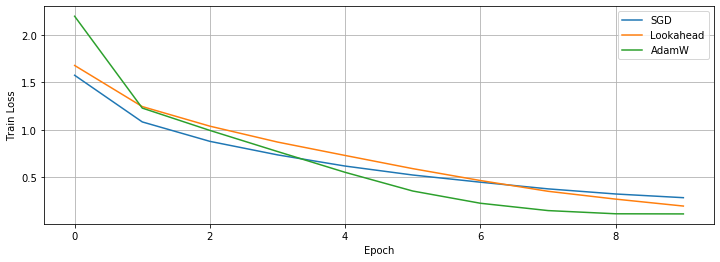

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))
names = ['SGD', 'Lookahead', 'AdamW']
for opt_name, result in zip(names, results):
    ax.plot(pd.DataFrame(result)['loss'], label=opt_name)

ax.set_ylabel("Train Loss")
ax.set_xlabel("Epoch")

ax.grid(True)
ax.legend()
plt.show()

In [25]:
for opt_name, result in zip(names, results):
    pd.DataFrame(result).to_csv("results_"+opt_name)